In [412]:
% matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

path = '/home/rbodo/.snntoolbox/data/imagenet/inception_averagepool/debug/video_input/with_reset'
mem8 = np.load(os.path.join(path, 'mem8.npy'))
mem14 = np.load(os.path.join(path, 'mem14.npy'))
inputspiketimes8 = np.load(os.path.join(path, 'inputspikes8.npy'))
inputspiketimes14 = np.load(os.path.join(path, 'inputspikes14.npy'))
inputspikes8 = (inputspiketimes8 > 0).astype('int')
inputspikes14 = (inputspiketimes14 > 0).astype('int')
weights8 = np.load(os.path.join(path, 'weights8.npy'))
weights14 = np.load(os.path.join(path, 'weights14.npy'))
bias8 = 0.3391836  # first feature map
bias14 = 0.9455142  # 5th feature map
T = len(mem8)

In [413]:
def get_input_voltage(spikes, weights, bias):
    return np.dot(spikes, weights) + bias

In [414]:
input8 = get_input_voltage(inputspikes8, weights8, bias8)
input14 = get_input_voltage(inputspikes14, weights14, bias14)

In [415]:
def get_membrane_potential(input_t, reset):
    v = 0
    v_t = []
    spikes_t = []
    for t in range(len(input_t)):
        v += input_t[t]
        if v >= 1:
            if reset == 'sub':
                v -= 1
            elif reset == 'zero':
                v = 0
            elif reset == 'mod':
                v %= 1
            spikes_t.append(t)
        v_t.append(v)
    return np.array(v_t), spikes_t

In [416]:
reset = 'sub'
mmem8, spikes8 = get_membrane_potential(input8, reset)
mmem14, spikes14 = get_membrane_potential(input14, reset)

In [417]:
mem_list = [mem8, mem14, mem14_clamped]
mmem_list = [mmem8, mmem14, mmem14_clamped]
results = []
for mem, mmem in zip(mem_list, mmem_list):
    results.append(np.isclose(mem - mmem, np.zeros_like(mem), atol=1e-5))
print(np.all(results))

False


In [418]:
def plot_spiketrains(spiketimes_layers, labels):
    num_layers = len(spiketimes_layers)
    f, ax = plt.subplots(num_layers, 1, sharex=True, sharey=True)
    f.set_figwidth(10)
    f.set_figheight(10 * num_layers)
    ax[-1].set_xlabel('t')
    for i, spiketimes in enumerate(spiketimes_layers):
        for (neuron, spiketrain) in enumerate(spiketimes.transpose()):
            spikelist = [j for j in spiketrain if j != 0]
            y = np.ones_like(spikelist) * neuron
            ax[i].plot(spikelist, y, '.')
            ax[i].set_title(labels[i])
            ax[i].set_ylabel('neuron index')
    f.savefig(os.path.join(path, 'input_spiketrains'))

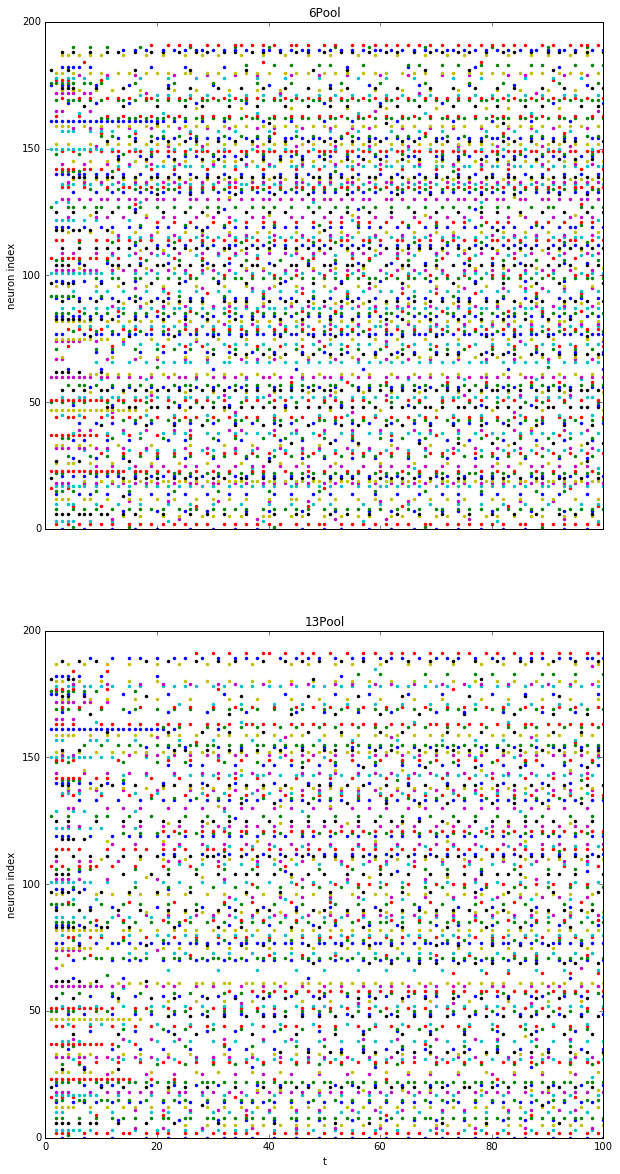

In [419]:
plot_spiketrains([inputspiketimes8, inputspiketimes14], ['6Pool', '13Pool'])

In [420]:
def get_rates(spiketimes, idx=0):
    rates = []
    count = 0
    for t in range(len(spiketimes)):
        count += int(spiketimes.transpose()[idx][t] > 0)
        rates.append(count/(t+1))
    return rates


def plot_spikerates(spiketimes_layers, labels, idx=0):
    plt.title('Spike-rates')
    plt.xlabel('t')
    for i, spiketimes in enumerate(spiketimes_layers):
        plt.plot(get_rates(spiketimes, idx), label=labels[i])
        plt.ylabel('spike-rate')
    plt.legend()
    plt.savefig(os.path.join(path, 'spikerates'))

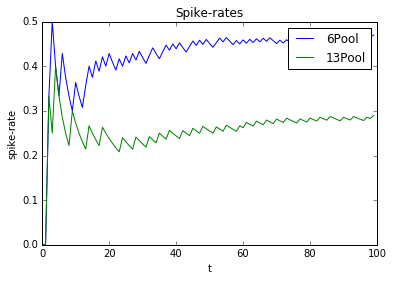

In [421]:
plot_spikerates([inputspiketimes8, inputspiketimes14], ['6Pool', '13Pool'], 135)

In [422]:
def plot_cumsum(input_t, labels):
    plt.title('Cumulated input')
    plt.xlabel('t')
    for i, inp in enumerate(input_t):
        plt.plot(np.cumsum(inp), label=labels[i])
        plt.ylabel('V')
    plt.legend()
    plt.savefig(os.path.join(path, 'cum_input'))

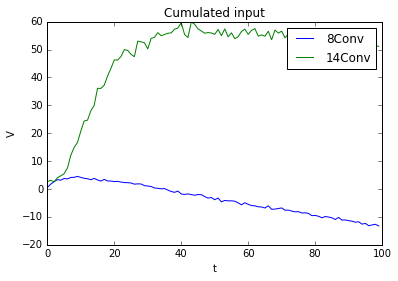

In [423]:
plot_cumsum([input8, input14], ['8Conv', '14Conv'])

In [424]:
input_list = [input8, input14, input14_clamped]
num_spikes_list = [len(spikes8), len(spikes14), len(spikes14_clamped)]
mem_list = [mem8[-1], mem14[-1], mem14_clamped[-1]]
results = []
for inp, num_spikes, mem in zip(input_list, num_spikes_list, mem_list):
    results.append(np.isclose(np.sum(inp) - num_spikes - mem, 0, atol=1e-5))
print(all(results))

False


In [425]:
def plot_vmem(mem_layers, spikes_layers, labels, title='V_mem'):
    num_layers = len(mem_layers)
    f, ax = plt.subplots(num_layers, 1, sharex=True, sharey=True)
    f.set_figheight(4 * num_layers)
    f.set_figwidth(10)
    ax[-1].set_xlabel('t')
    for i in range(num_layers):
        ax[i].plot(mem_layers[i], label='V_mem')
        ax[i].plot(spikes_layers[i], np.ones_like(spikes_layers[i]), '.', label='spikes')
        ax[i].set_title(labels[i])
        ax[i].set_xlabel('t')
        ax[i].legend()
    f.savefig(os.path.join(path, title))

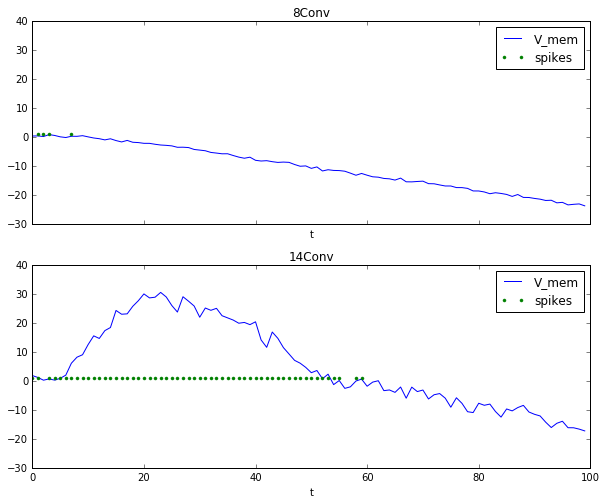

In [426]:
plot_vmem([mem8, mem14], [spikes8, spikes14], ['8Conv', '14Conv'])

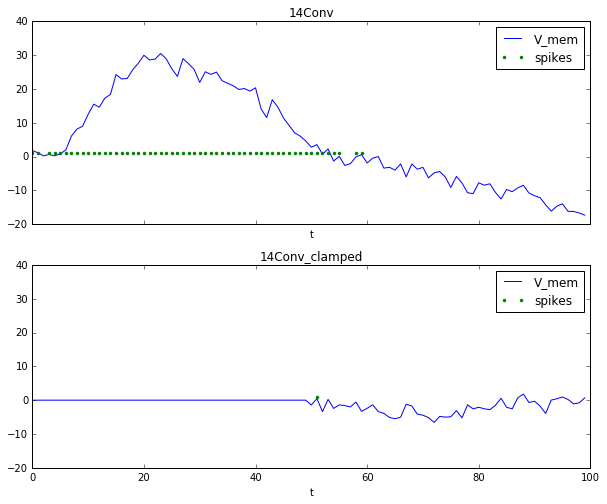

In [427]:
mem14_clamped = np.load(os.path.join(path, 'mem14_clamped.npy'))
input14_clamped = []
for i in range(len(input14)):
    if i < 50:
        input14_clamped.append(0)
    else:
        input14_clamped.append(input14[i])
mmem14_clamped, spikes14_clamped = get_membrane_potential(input14_clamped, reset)
plot_vmem([mem14, mem14_clamped], [spikes14, spikes14_clamped], ['14Conv', '14Conv_clamped'], 'V_mem_clamped')